# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

sum_sq    df         F    PR(>F)  p_val_adj
A1BG   0.122578  12.0  2.796490  0.003701   0.010364
AAAS   0.017527  12.0  0.944161  0.509517   0.596369
AACS   0.136394  12.0  2.729393  0.004508   0.012212
AADAT  0.057031  12.0  5.478881  0.000002   0.000016
AAGAB  0.043359  12.0  2.127609  0.026045   0.053640

In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = '../data/pseudobulks/'

In [8]:
os.listdir(pb_dir_path)

['pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [11]:
import pickle
with open("./results/specie_specific_genes_tr28.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

## Helpful functions

In [12]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [13]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [14]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [15]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [16]:
ms_genes = genes_dict77['macaque']

In [17]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_ms = df[ms_genes]

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


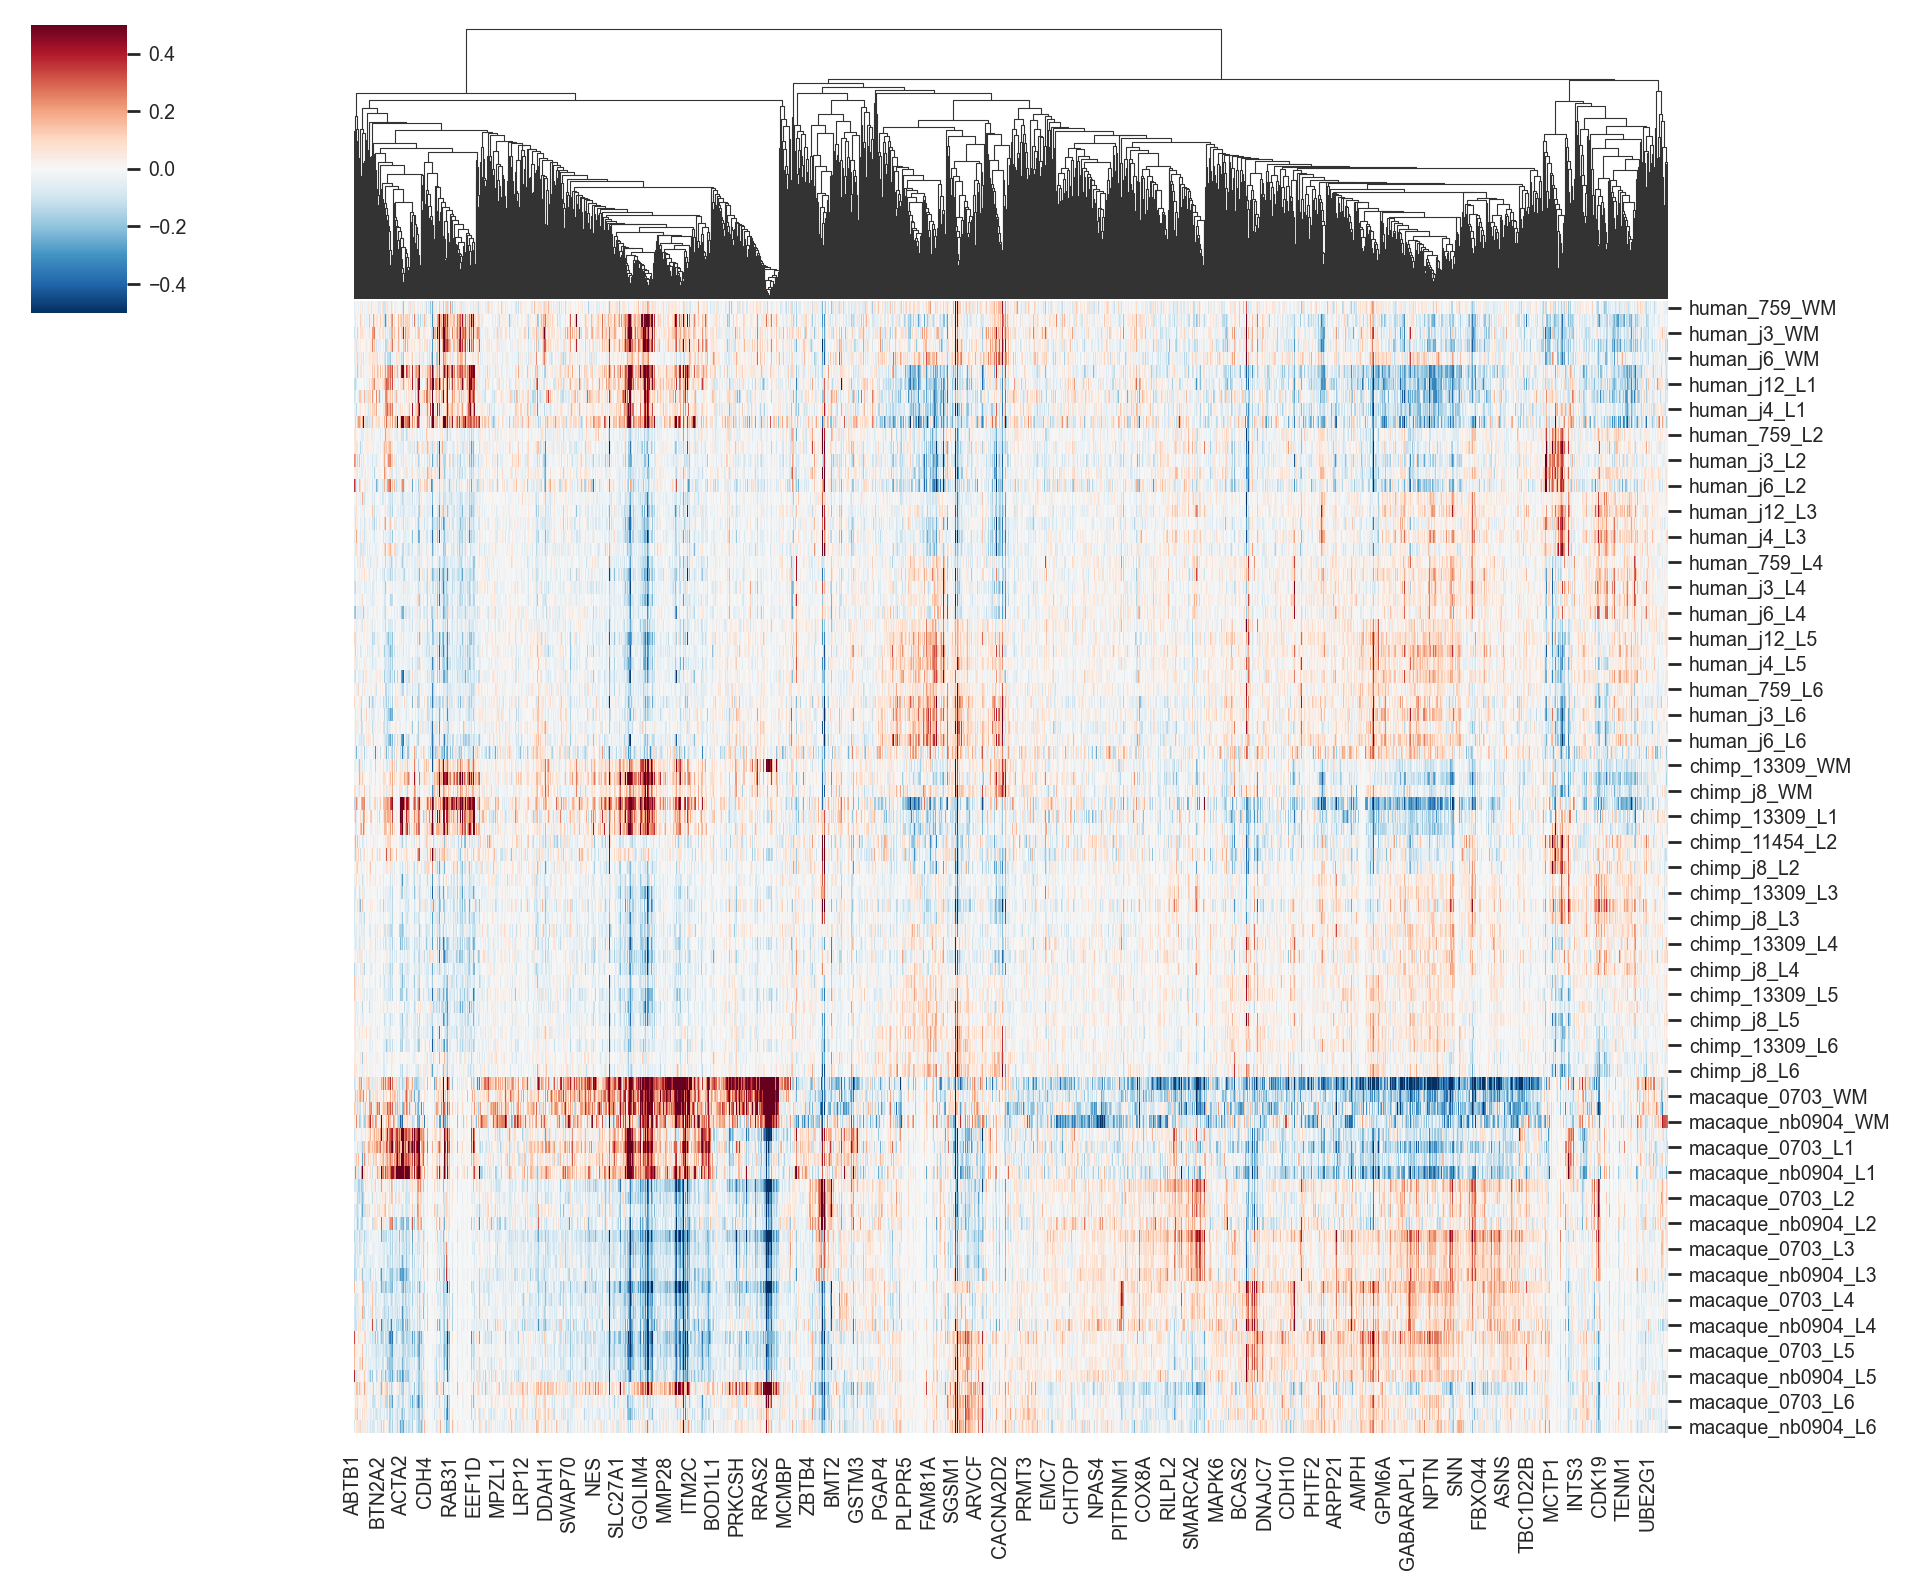

In [18]:
sns.set(font_scale=0.8)
sns.clustermap(df_ms, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [19]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_ms.loc[sample_order['macaque']].T, metric='cosine') + 1
n_clusters = 6
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)

SpectralClustering(affinity='precomputed', gamma=1, n_clusters=6,
                   random_state=4)

In [20]:
labels = pd.Series(clustering.labels_, index=ms_genes).sort_values()
order = labels.sort_values().index

In [21]:
labels.to_csv('./results/macaque_clusters_28.csv')

<Axes: >

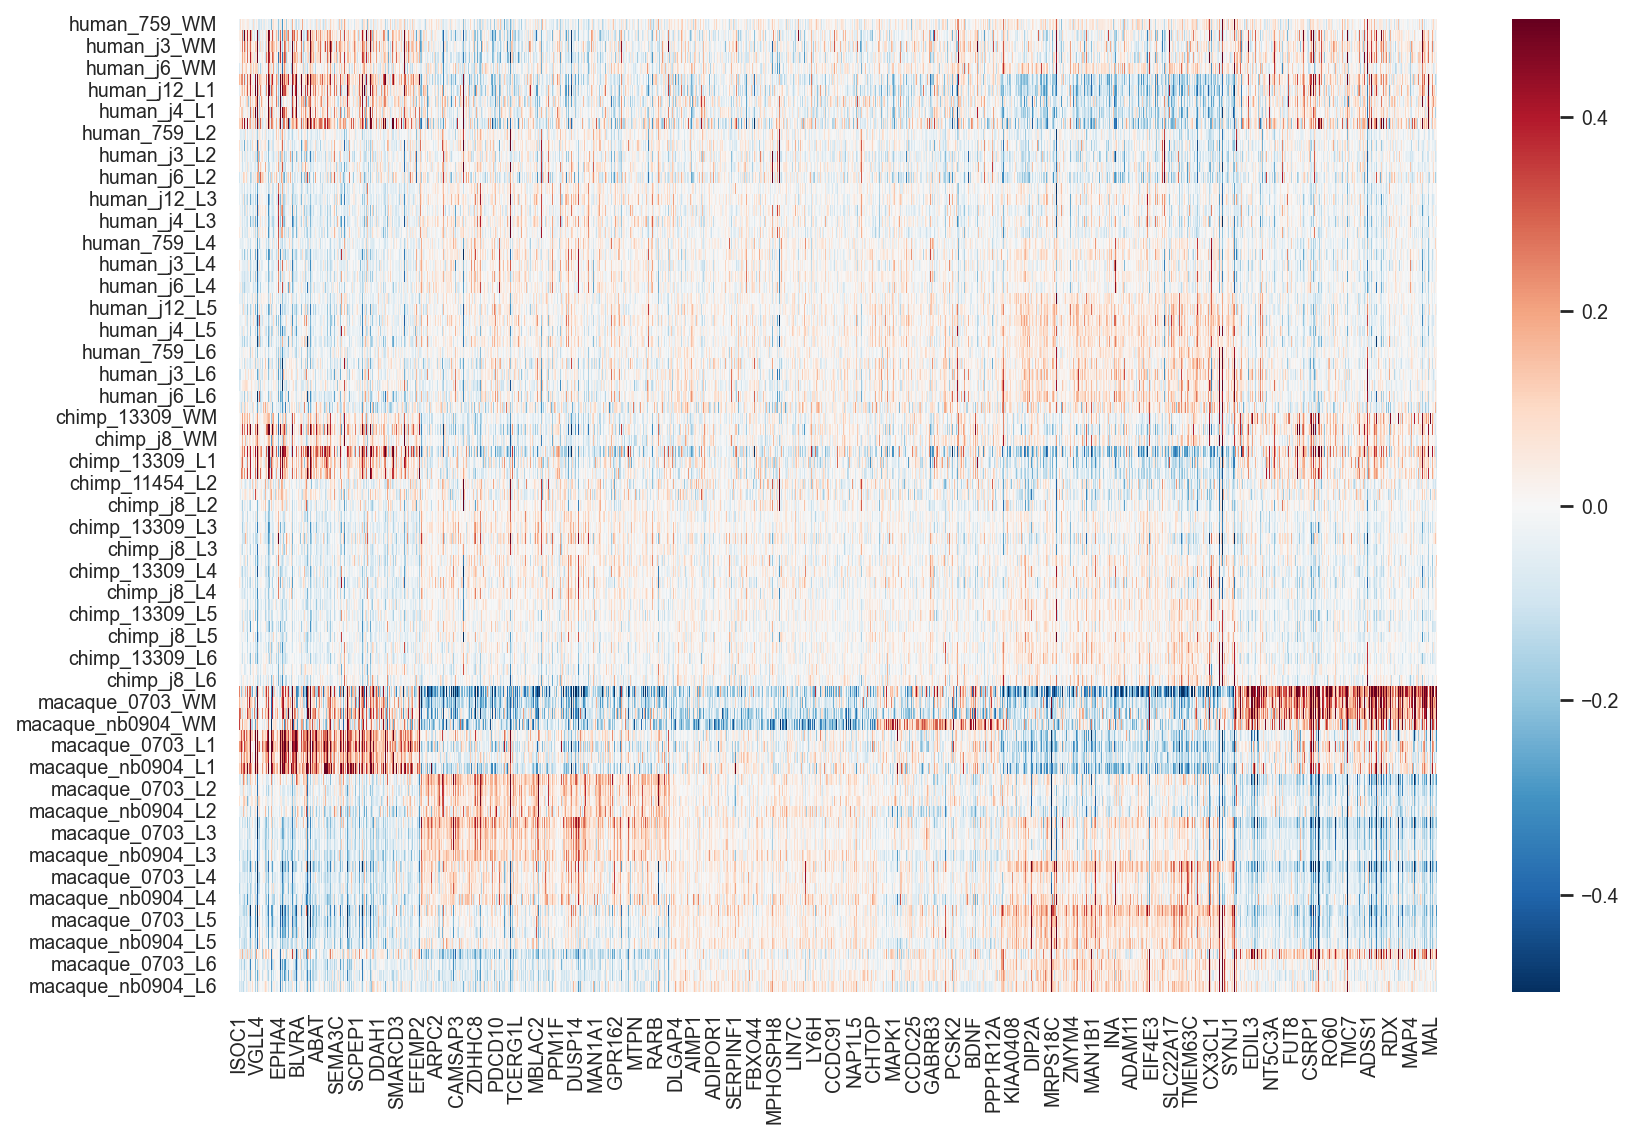

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_ms[order], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)

## Cluster profiles

In [23]:
df_annotation = df_ms.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [24]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

A1BG      AACS     AARS1  AASDHPPT      AASS      AATK  \
condition layer                                                               
chimp     L1     0.000311 -0.067096  0.015548 -0.129857  0.108528 -0.030878   
          L2    -0.025557 -0.121551 -0.027253  0.004536 -0.014298 -0.065565   
          L3     0.076603 -0.020433 -0.005945  0.040311 -0.059288 -0.000613   
          L4     0.062482  0.042894 -0.009535  0.054389 -0.031290  0.005079   
          L5    -0.010620  0.077460 -0.010588  0.018721 -0.039158  0.047233   

                     ABAT     ABCA2    ABCC10     ABCD3  ...    ZNF644  \
condition layer                                          ...             
chimp     L1    -0.005831 -0.000803  0.012161  0.042827  ...  0.038553   
          L2    -0.089762 -0.000803  0.007172  0.068865  ...  0.023158   
          L3    -0.051850  0.003244 -0.008038  0.031032  ... -0.016845   
          L4     0.036816 -0.001952  0.024499 -0.023390  ... -0.012066   
          L5     0.086123 -0.001801 -0.001435 -0.021821  ... -0.036636   

                   ZNF655    ZNF664    ZNF689    ZNF703    ZNF711    ZNF768  \
condition layer                                                               
chimp     L1     0.001688 -0.001561 -0.054518  0.091272 -0.088315 -0.019681   
          L2     0.057636 -0.001561 -0.025408  0.000917  0.119109  0.064370   
          L3    -0.018696 -0.001409 -0.021167 -0.013615 -0.019387 -0.030899   
          L4    -0.037499  0.001077  0.046568 -0.045401 -0.021220  0.002458   
          L5    -0.019257 -0.001409 -0.012277 -0.026256  0.016045 -0.025116   

                   ZNF791    ZNHIT1    ZNHIT3  
condition layer                                
chimp     L1     0.060992  0.010414 -0.000925  
          L2    -0.006265 -0.001379  0.045854  
          L3     0.006503 -0.000232  0.005685  
          L4    -0.034777  0.003776 -0.006129  
          L5    -0.015340 -0.002911  0.004999  

[5 rows x 3016 columns]

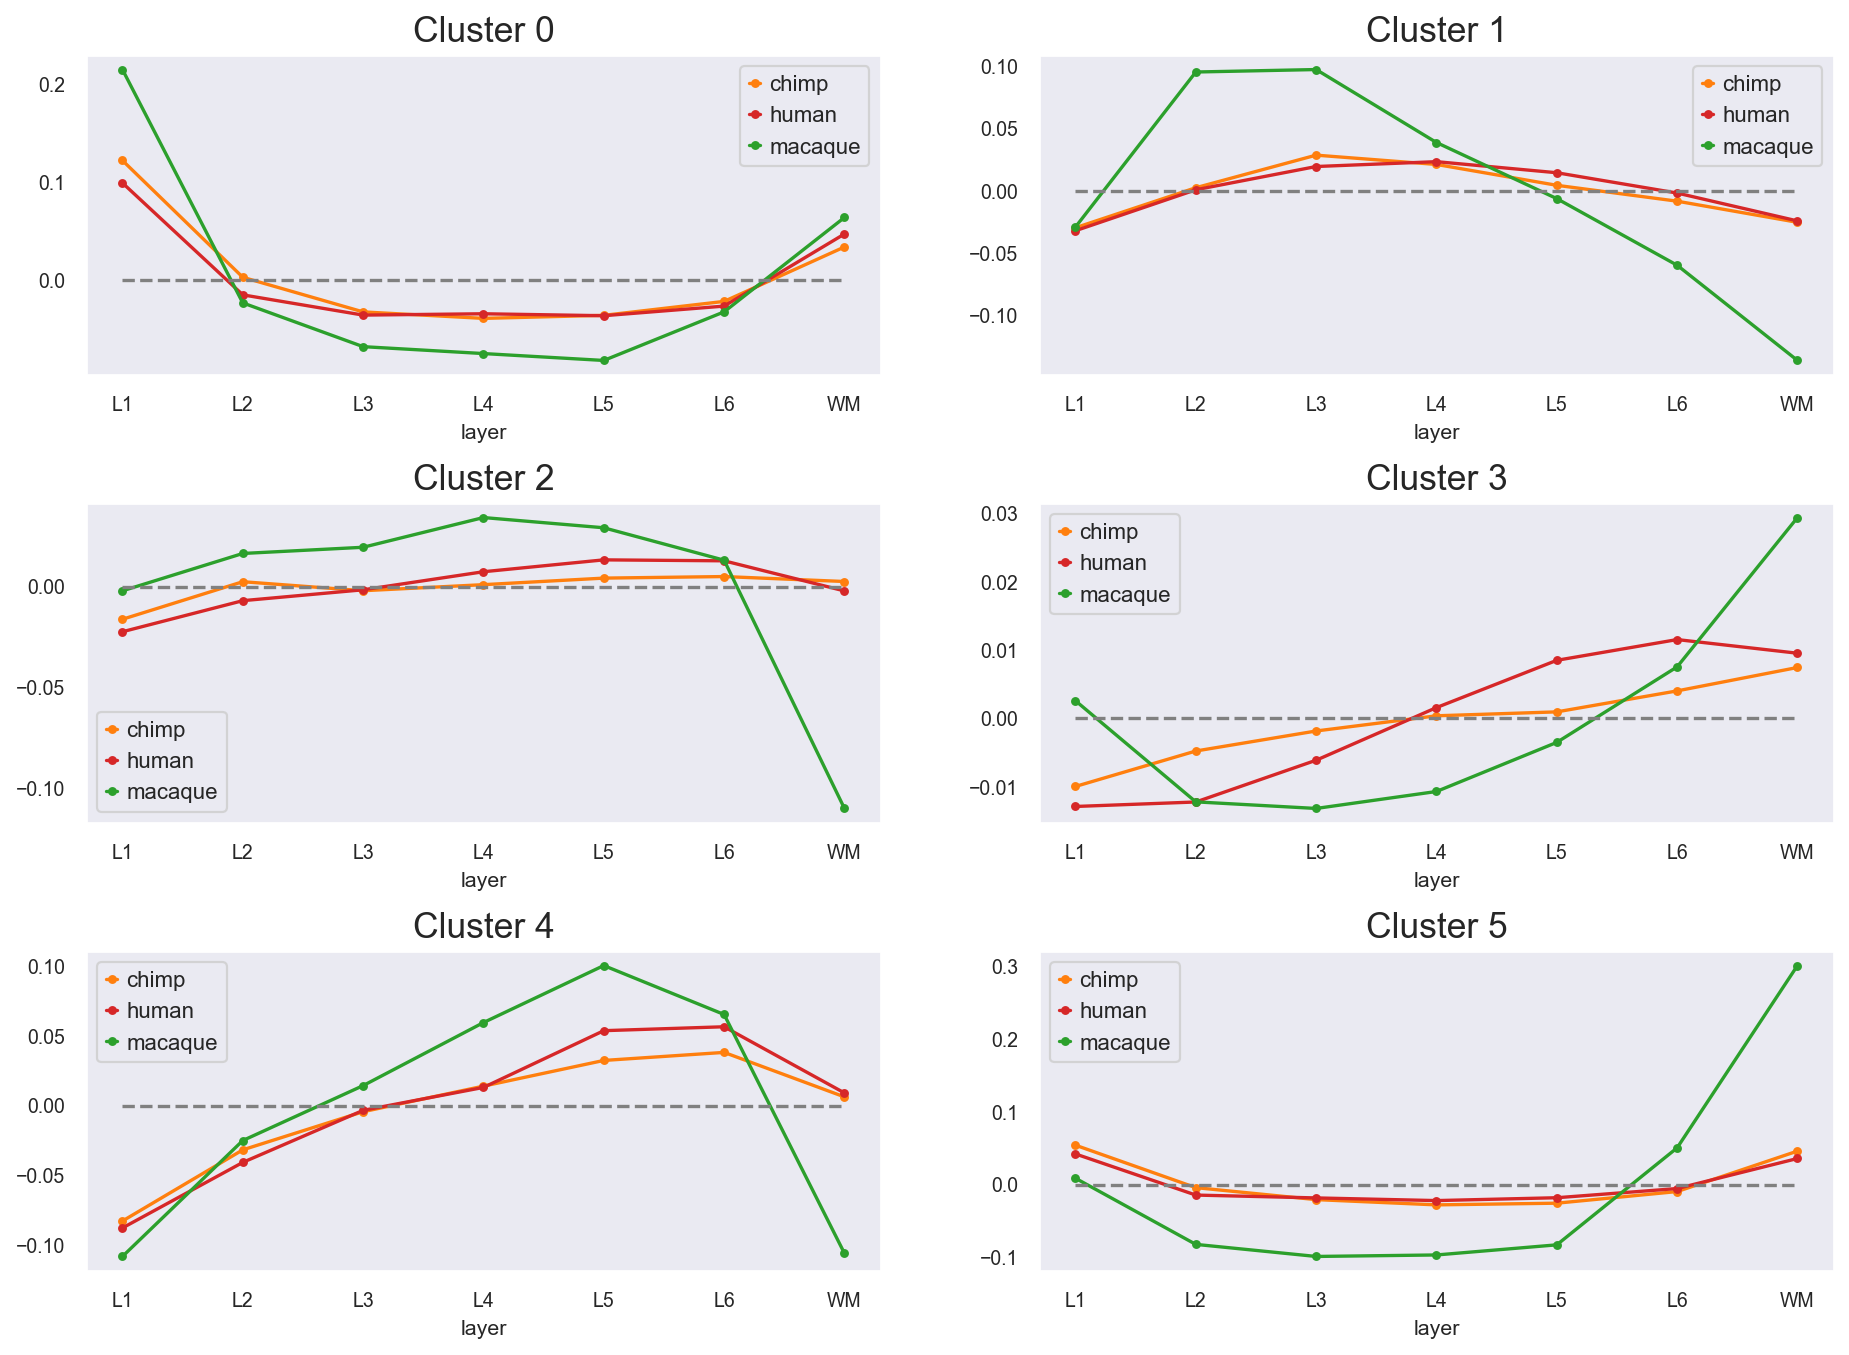

In [25]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

# Intersection with ANOVA clusters

In [26]:
anova_ms_inter = ms_genes.intersection(anova_labels.index)
anova_ms_inter

Index(['A1BG', 'AACS', 'AARS1', 'AATK', 'ABAT', 'ABCA2', 'ABCC10', 'ABCD4',
       'ABHD10', 'ABHD17A',
       ...
       'ZNF511', 'ZNF536', 'ZNF576', 'ZNF581', 'ZNF655', 'ZNF664', 'ZNF689',
       'ZNF703', 'ZNF768', 'ZNF791'],
      dtype='object', length=2445)

In [27]:
table_to_pivot = pd.concat([anova_labels.loc[anova_ms_inter], labels.loc[anova_ms_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'ms_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

ms_labels       0    1    2   3    4    5
ANOVA_labels                             
0              38   36   42  17   21   22
1               5   24  179  15  313    3
2              30   42   46  40   59   23
3              22    3    1  70   13  332
4             128   34   83   9    8   22
5               4  355   37  37   51    2
6             134   27   41  23   10   44

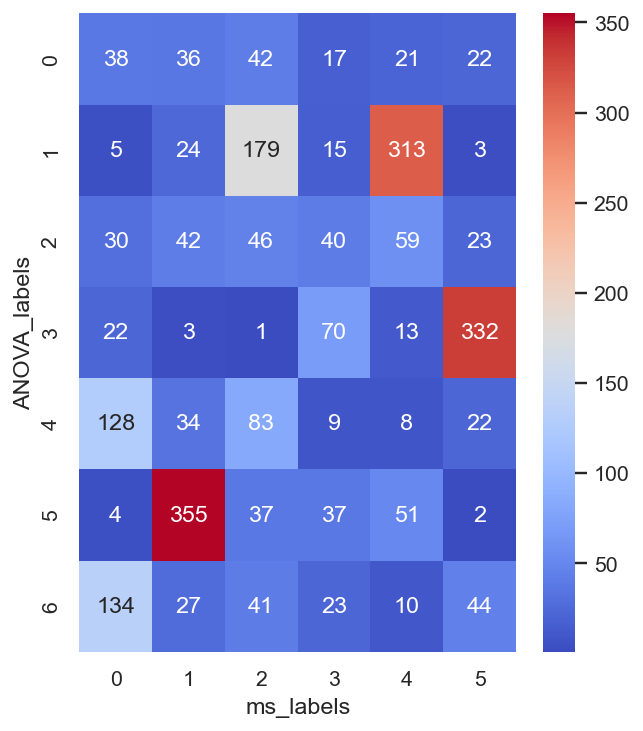

In [28]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

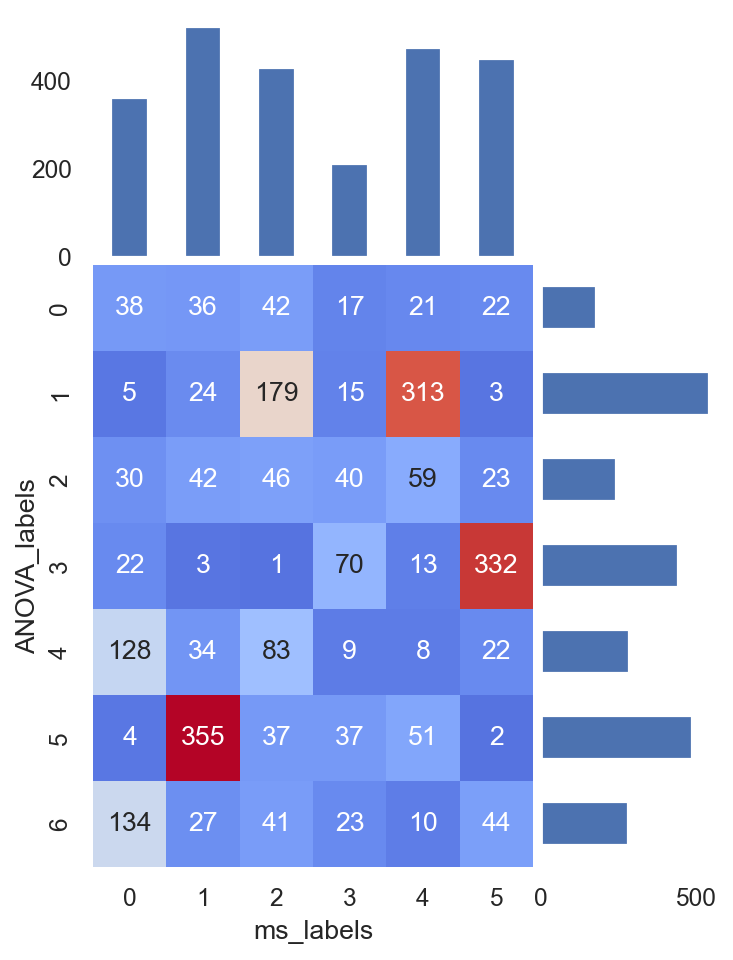

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', center=160, fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [30]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of macaque-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/6 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [31]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [32]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank         p-val  \
Term                                                                     
extracellular matrix organization (GO:0030198)         1  6.157914e-08   
external encapsulating structure organization (...     2  1.942448e-06   
extracellular structure organization (GO:0043062)      3  2.334843e-06   
gamma-aminobutyric acid transport (GO:0015812)         4  2.928221e-05   
positive regulation of cell differentiation (GO...     5  3.030853e-05   

                                                      Z-score  Combined score  \
Term                                                                            
extracellular matrix organization (GO:0030198)       4.773579       79.255458   
external encapsulating structure organization (...   5.151731       67.753304   
extracellular structure organization (GO:0043062)    5.062325       65.646036   
gamma-aminobutyric acid transport (GO:0015812)      76.905495      802.780352   
positive regulation of cell differentiation (GO...   3.270833       34.030016   

                                                                                    Overlapping genes  \
Term                                                                                                    
extracellular matrix organization (GO:0030198)      [ITGB1, CRTAP, COLGALT2, CD151, LAMB2, ELN, FN...   
external encapsulating structure organization (...  [ITGB1, LAMB2, ELN, FN1, BGN, HAPLN1, DCN, COL...   
extracellular structure organization (GO:0043062)   [ITGB1, LAMB2, ELN, FN1, BGN, HAPLN1, DCN, COL...   
gamma-aminobutyric acid transport (GO:0015812)                   [SLC9A3R1, SLC6A12, SLC6A11, SLC6A1]   
positive regulation of cell differentiation (GO...  [SPAG9, SYAP1, LPL, PTN, MAPK12, COL1A1, TMEM1...   

                                                    Adjusted P-value  \
Term                                                                   
extracellular matrix organization (GO:0030198)              0.000175   
external encapsulating structure organization (...          0.002214   
extracellular structure organization (GO:0043062)           0.002214   
gamma-aminobutyric acid transport (GO:0015812)              0.012277   
positive regulation of cell differentiation (GO...          0.012277   

                                                    Old p-value  \
Term                                                              
extracellular matrix organization (GO:0030198)                0   
external encapsulating structure organization (...            0   
extracellular structure organization (GO:0043062)             0   
gamma-aminobutyric acid transport (GO:0015812)                0   
positive regulation of cell differentiation (GO...            0   

                                                    Old adjusted p-value  \
Term                                                                       
extracellular matrix organization (GO:0030198)                         0   
external encapsulating structure organization (...                     0   
extracellular structure organization (GO:0043062)                      0   
gamma-aminobutyric acid transport (GO:0015812)                         0   
positive regulation of cell differentiation (GO...                     0   

                                                    num_overlap_genes  \
Term                                                                    
extracellular matrix organization (GO:0030198)                     21   
external encapsulating structure organization (...                 15   
extracellular structure organization (GO:0043062)                  15   
gamma-aminobutyric acid transport (GO:0015812)                      4   
positive regulation of cell differentiation (GO...                 19   

                                                    neg_log10(p_adj)  \
Term                                                                   
extracellular matrix organization (GO:0030198)              3.756

In [33]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

36

In [34]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

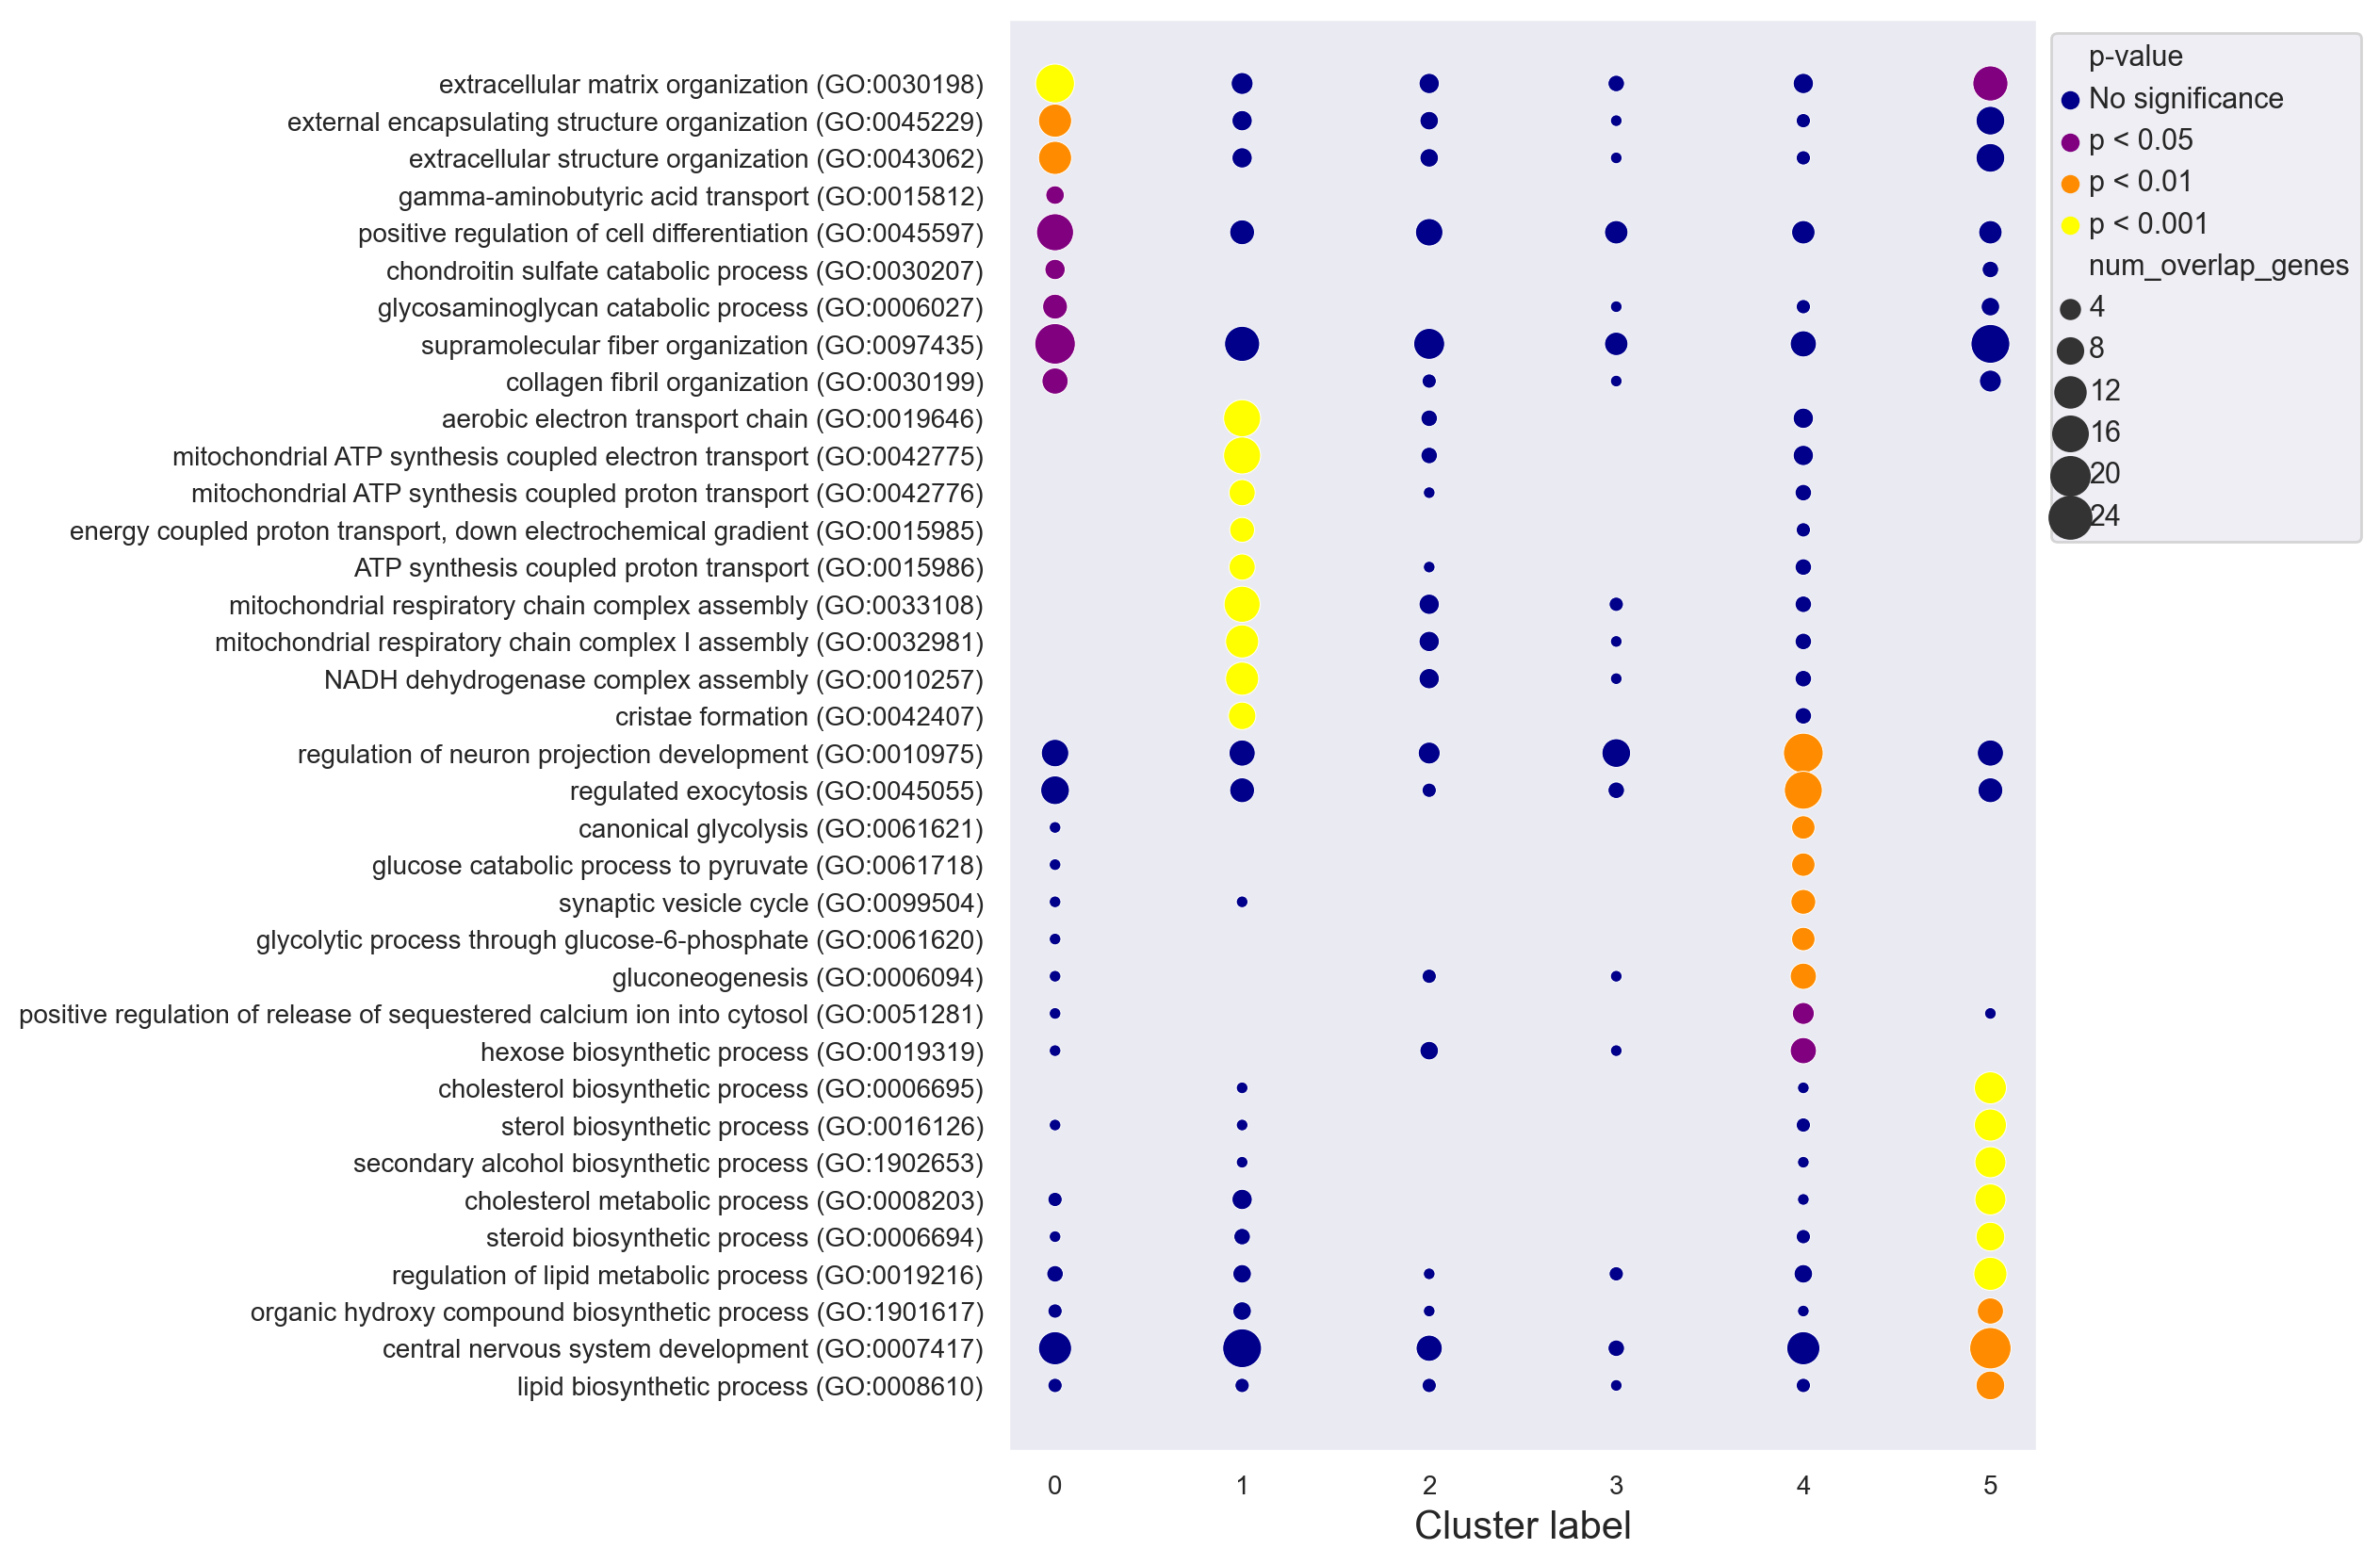

In [35]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [36]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [37]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
Astrocyte 2 CL0000127                                  1  0.000084  38.448352   
Vascular Lepotomeningeal Cell CL2000043                2  0.000123        inf   
Activated Stellate CL0002410                           3  0.000189  25.629304   
Adventitial Fibroblast CL0000057                       4  0.000363  19.219780   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...     5  0.000474  57.552632   

                                                    Combined score  \
Term                                                                 
Astrocyte 2 CL0000127                                   360.652958   
Vascular Lepotomeningeal Cell CL2000043                        inf   
Activated Stellate CL0002410                            219.722720   
Adventitial Fibroblast CL0000057                        152.222613   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...      440.516529   

                                                               Overlapping genes  \
Term                                                                               
Astrocyte 2 CL0000127                                [GJB6, SLC1A3, APOE, FGFR3]   
Vascular Lepotomeningeal Cell CL2000043                  [ITIH5, COL1A2, COL6A2]   
Activated Stellate CL0002410                        [COL1A1, COL1A2, SFRP2, BGN]   
Adventitial Fibroblast CL0000057                     [SFRP2, FBLN1, IGFBP6, DCN]   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...       [ITIH5, COL1A2, COL6A2]   

                                                    Adjusted P-value  \
Term                                                                   
Astrocyte 2 CL0000127                                       0.008124   
Vascular Lepotomeningeal Cell CL2000043                     0.008124   
Activated Stellate CL0002410                                0.008321   
Adventitial Fibroblast CL0000057                            0.011991   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...          0.012516   

                                                    Old p-value  \
Term                                                              
Astrocyte 2 CL0000127                                         0   
Vascular Lepotomeningeal Cell CL2000043                       0   
Activated Stellate CL0002410                                  0   
Adventitial Fibroblast CL0000057                              0   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Astrocyte 2 CL0000127                                                  0   
Vascular Lepotomeningeal Cell CL2000043                                0   
Activated Stellate CL0002410                                           0   
Adventitial Fibroblast CL0000057                                       0   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Astrocyte 2 CL0000127                                               4   
Vascular Lepotomeningeal Cell CL2000043                             3   
Activated Stellate CL0002410                                        4   
Adventitial Fibroblast CL0000057                                    4   
PDGFRA+ COLEC12+ Layer 1-5 Vascular Lepotomenin...                  3   

                                                    neg_log10(p_adj)  \
Term                                                                   
Astrocyte 2 CL0000127                                       2.090233   
Vascular Lepotomeningeal Cell CL2000043                     2.090233   
Activated Stellate CL0002410                                2.079800   
Adventitial Fibroblast C

In [38]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

17

In [39]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

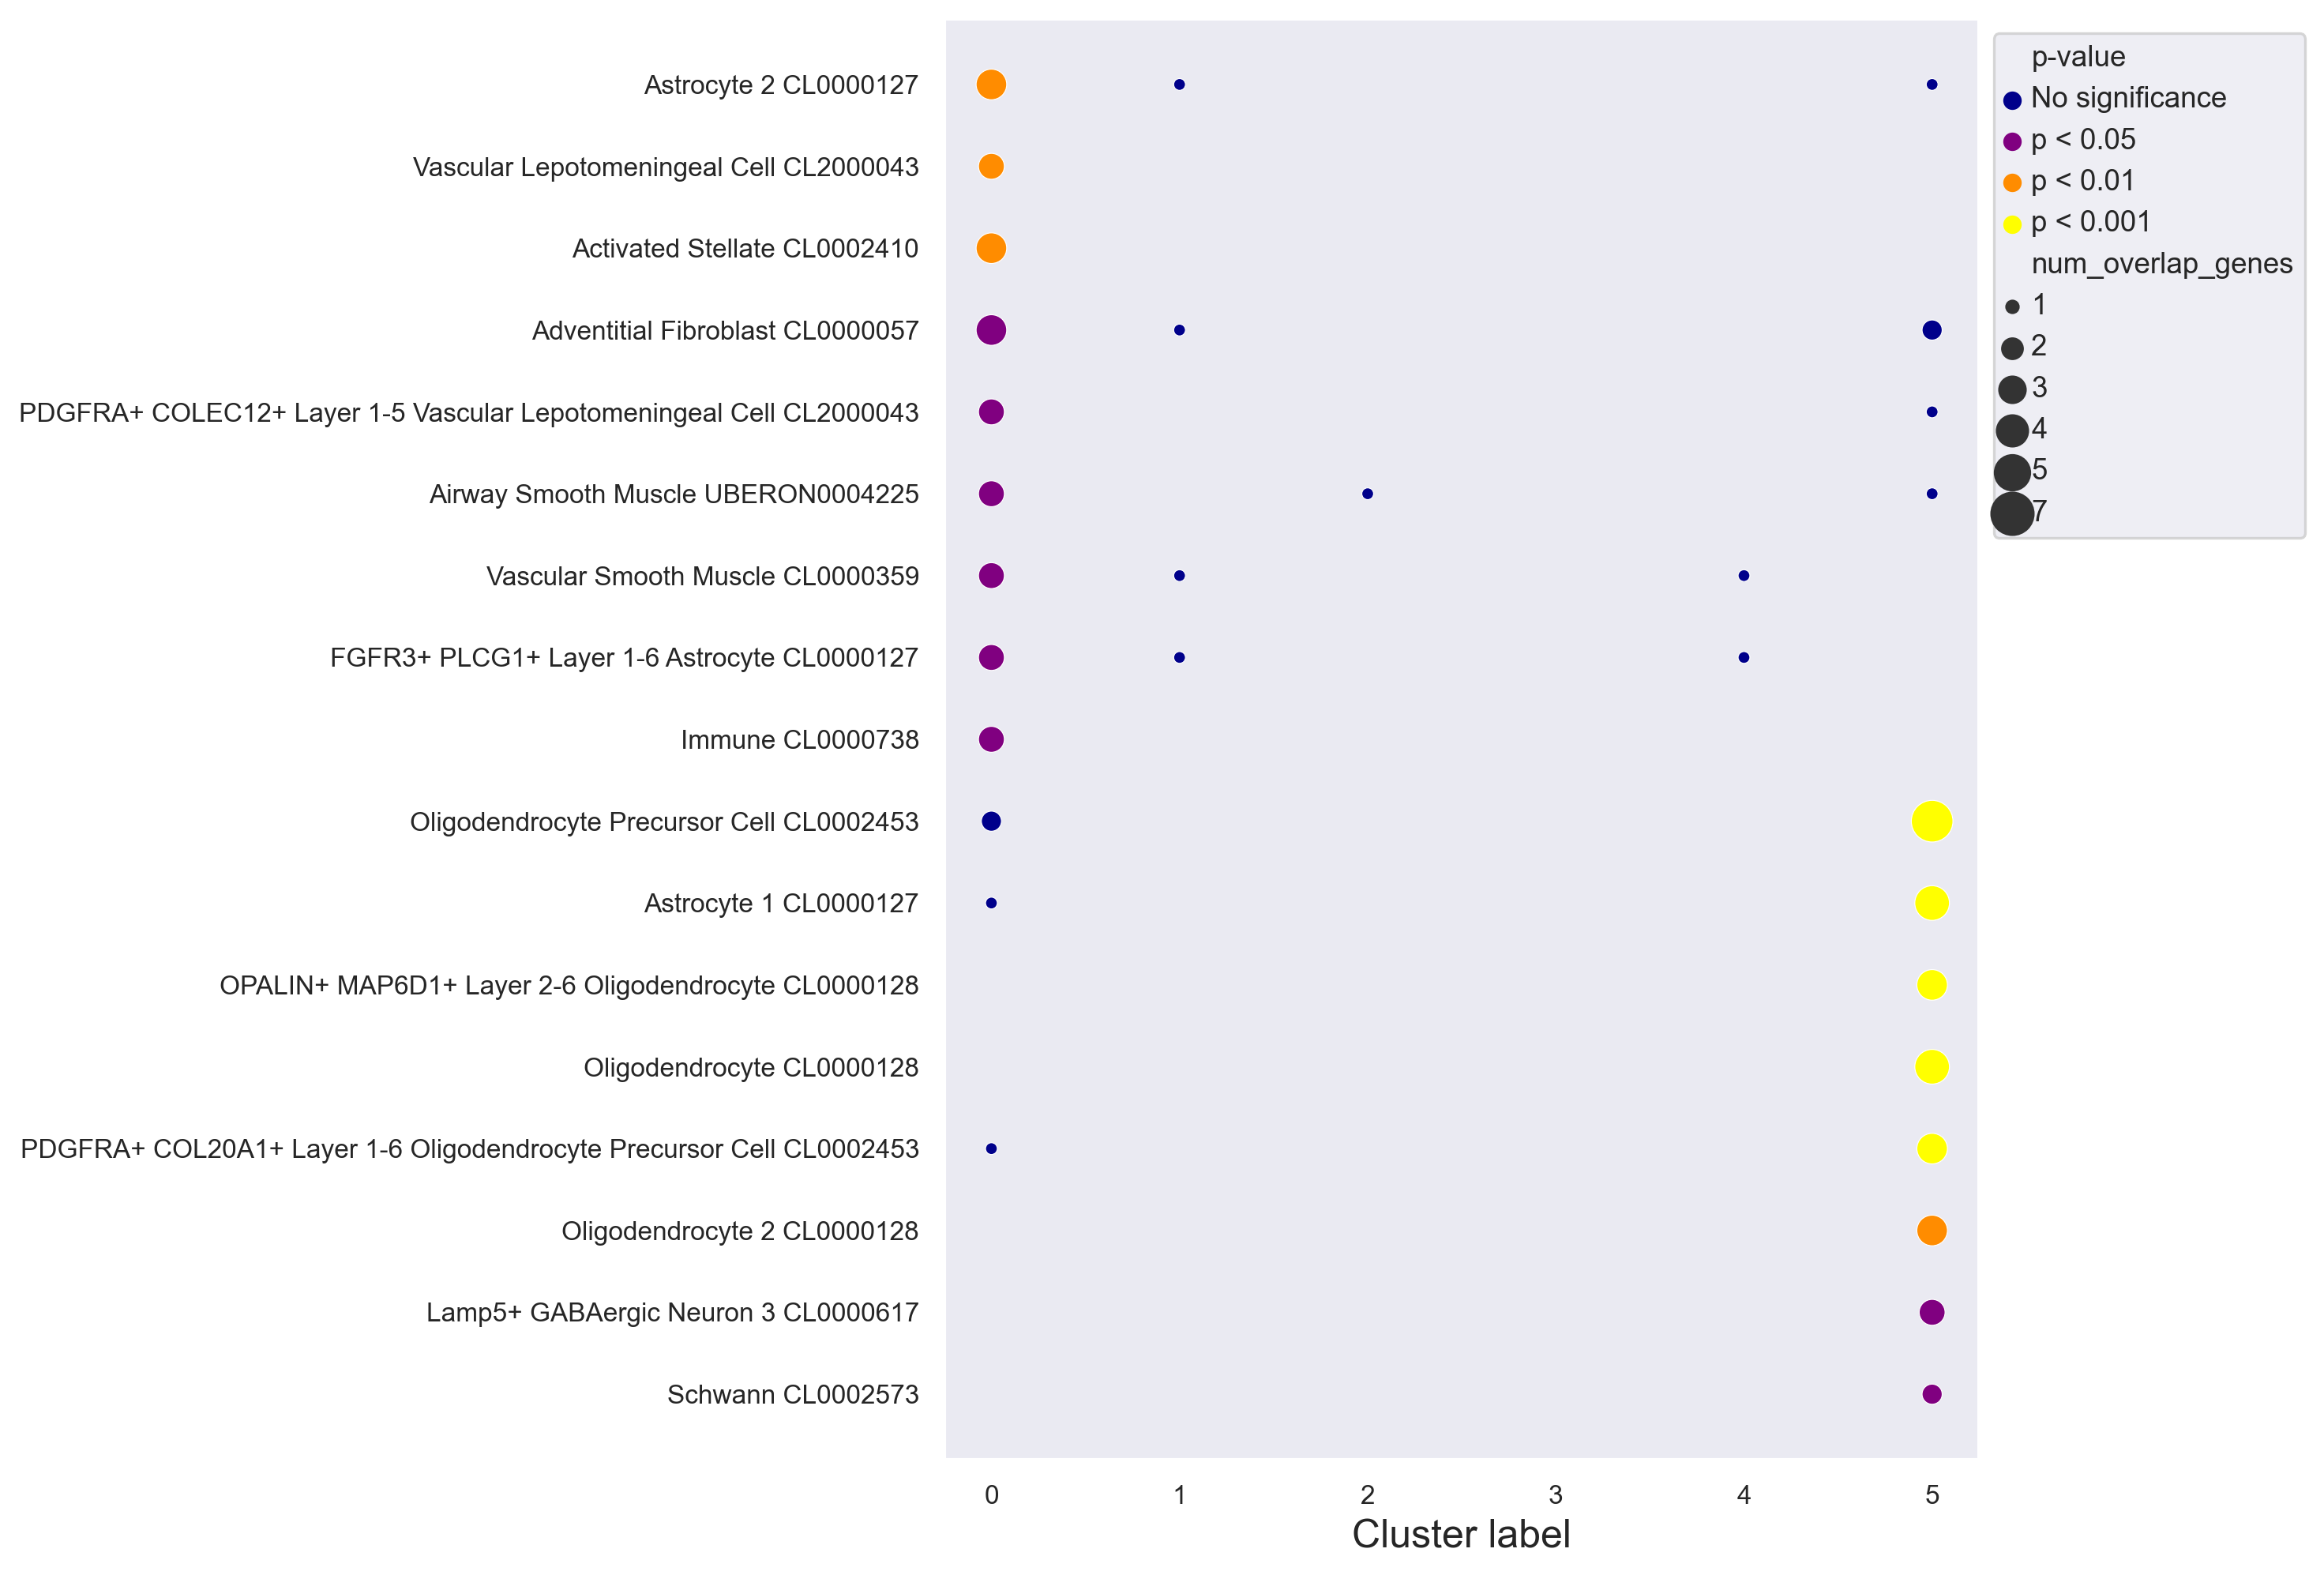

In [40]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [41]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [42]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                              
aneurysm MP:0003279                      1  0.000006        inf   
coarse hair MP:0002832                   2  0.000006        inf   
hemorrhage MP:0001914                    3  0.000047   2.948288   
abnormal placing response MP:0001526     4  0.000084  38.448352   
scoliosis MP:0000161                     5  0.000089   8.452848   

                                      Combined score  \
Term                                                   
aneurysm MP:0003279                              inf   
coarse hair MP:0002832                           inf   
hemorrhage MP:0001914                      29.372344   
abnormal placing response MP:0001526      360.652958   
scoliosis MP:0000161                       78.822970   

                                                                      Overlapping genes  \
Term                                                                                      
aneurysm MP:0003279                                       [COL1A1, EFEMP2, PARVA, KLF2]   
coarse hair MP:0002832                                     [COL1A1, EFEMP1, IDS, VEGFA]   
hemorrhage MP:0001914                 [ITGB1, BRD2, DDX3X, SMARCD3, EPAS1, FN1, PARV...   
abnormal placing response MP:0001526                           [EPHA4, MYO6, CPE, RND3]   
scoliosis MP:0000161                   [COL1A1, BRD2, GATM, NFIX, COL1A2, FGFR3, VEGFA]   

                                      Adjusted P-value  Old p-value  \
Term                                                                  
aneurysm MP:0003279                           0.007561            0   
coarse hair MP:0002832                        0.007561            0   
hemorrhage MP:0001914                         0.038964            0   
abnormal placing response MP:0001526          0.044226            0   
scoliosis MP:0000161                          0.044226            0   

                                      Old adjusted p-value  num_overlap_genes  \
Term                                                                            
aneurysm MP:0003279                                      0                  4   
coarse hair MP:0002832                                   0                  4   
hemorrhage MP:0001914                                    0                 21   
abnormal placing response MP:0001526                     0                  4   
scoliosis MP:0000161                                     0                  7   

                                      neg_log10(p_adj)  cluster_label  
Term                                                                   
aneurysm MP:0003279                           2.121427              0  
coarse hair MP:0002832                        2.121427              0  
hemorrhage MP:0001914                         1.409333              0  
abnormal placing response MP:0001526          1.354322              0  
scoliosis MP:0000161                          1.354322              0

In [43]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

13

In [44]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

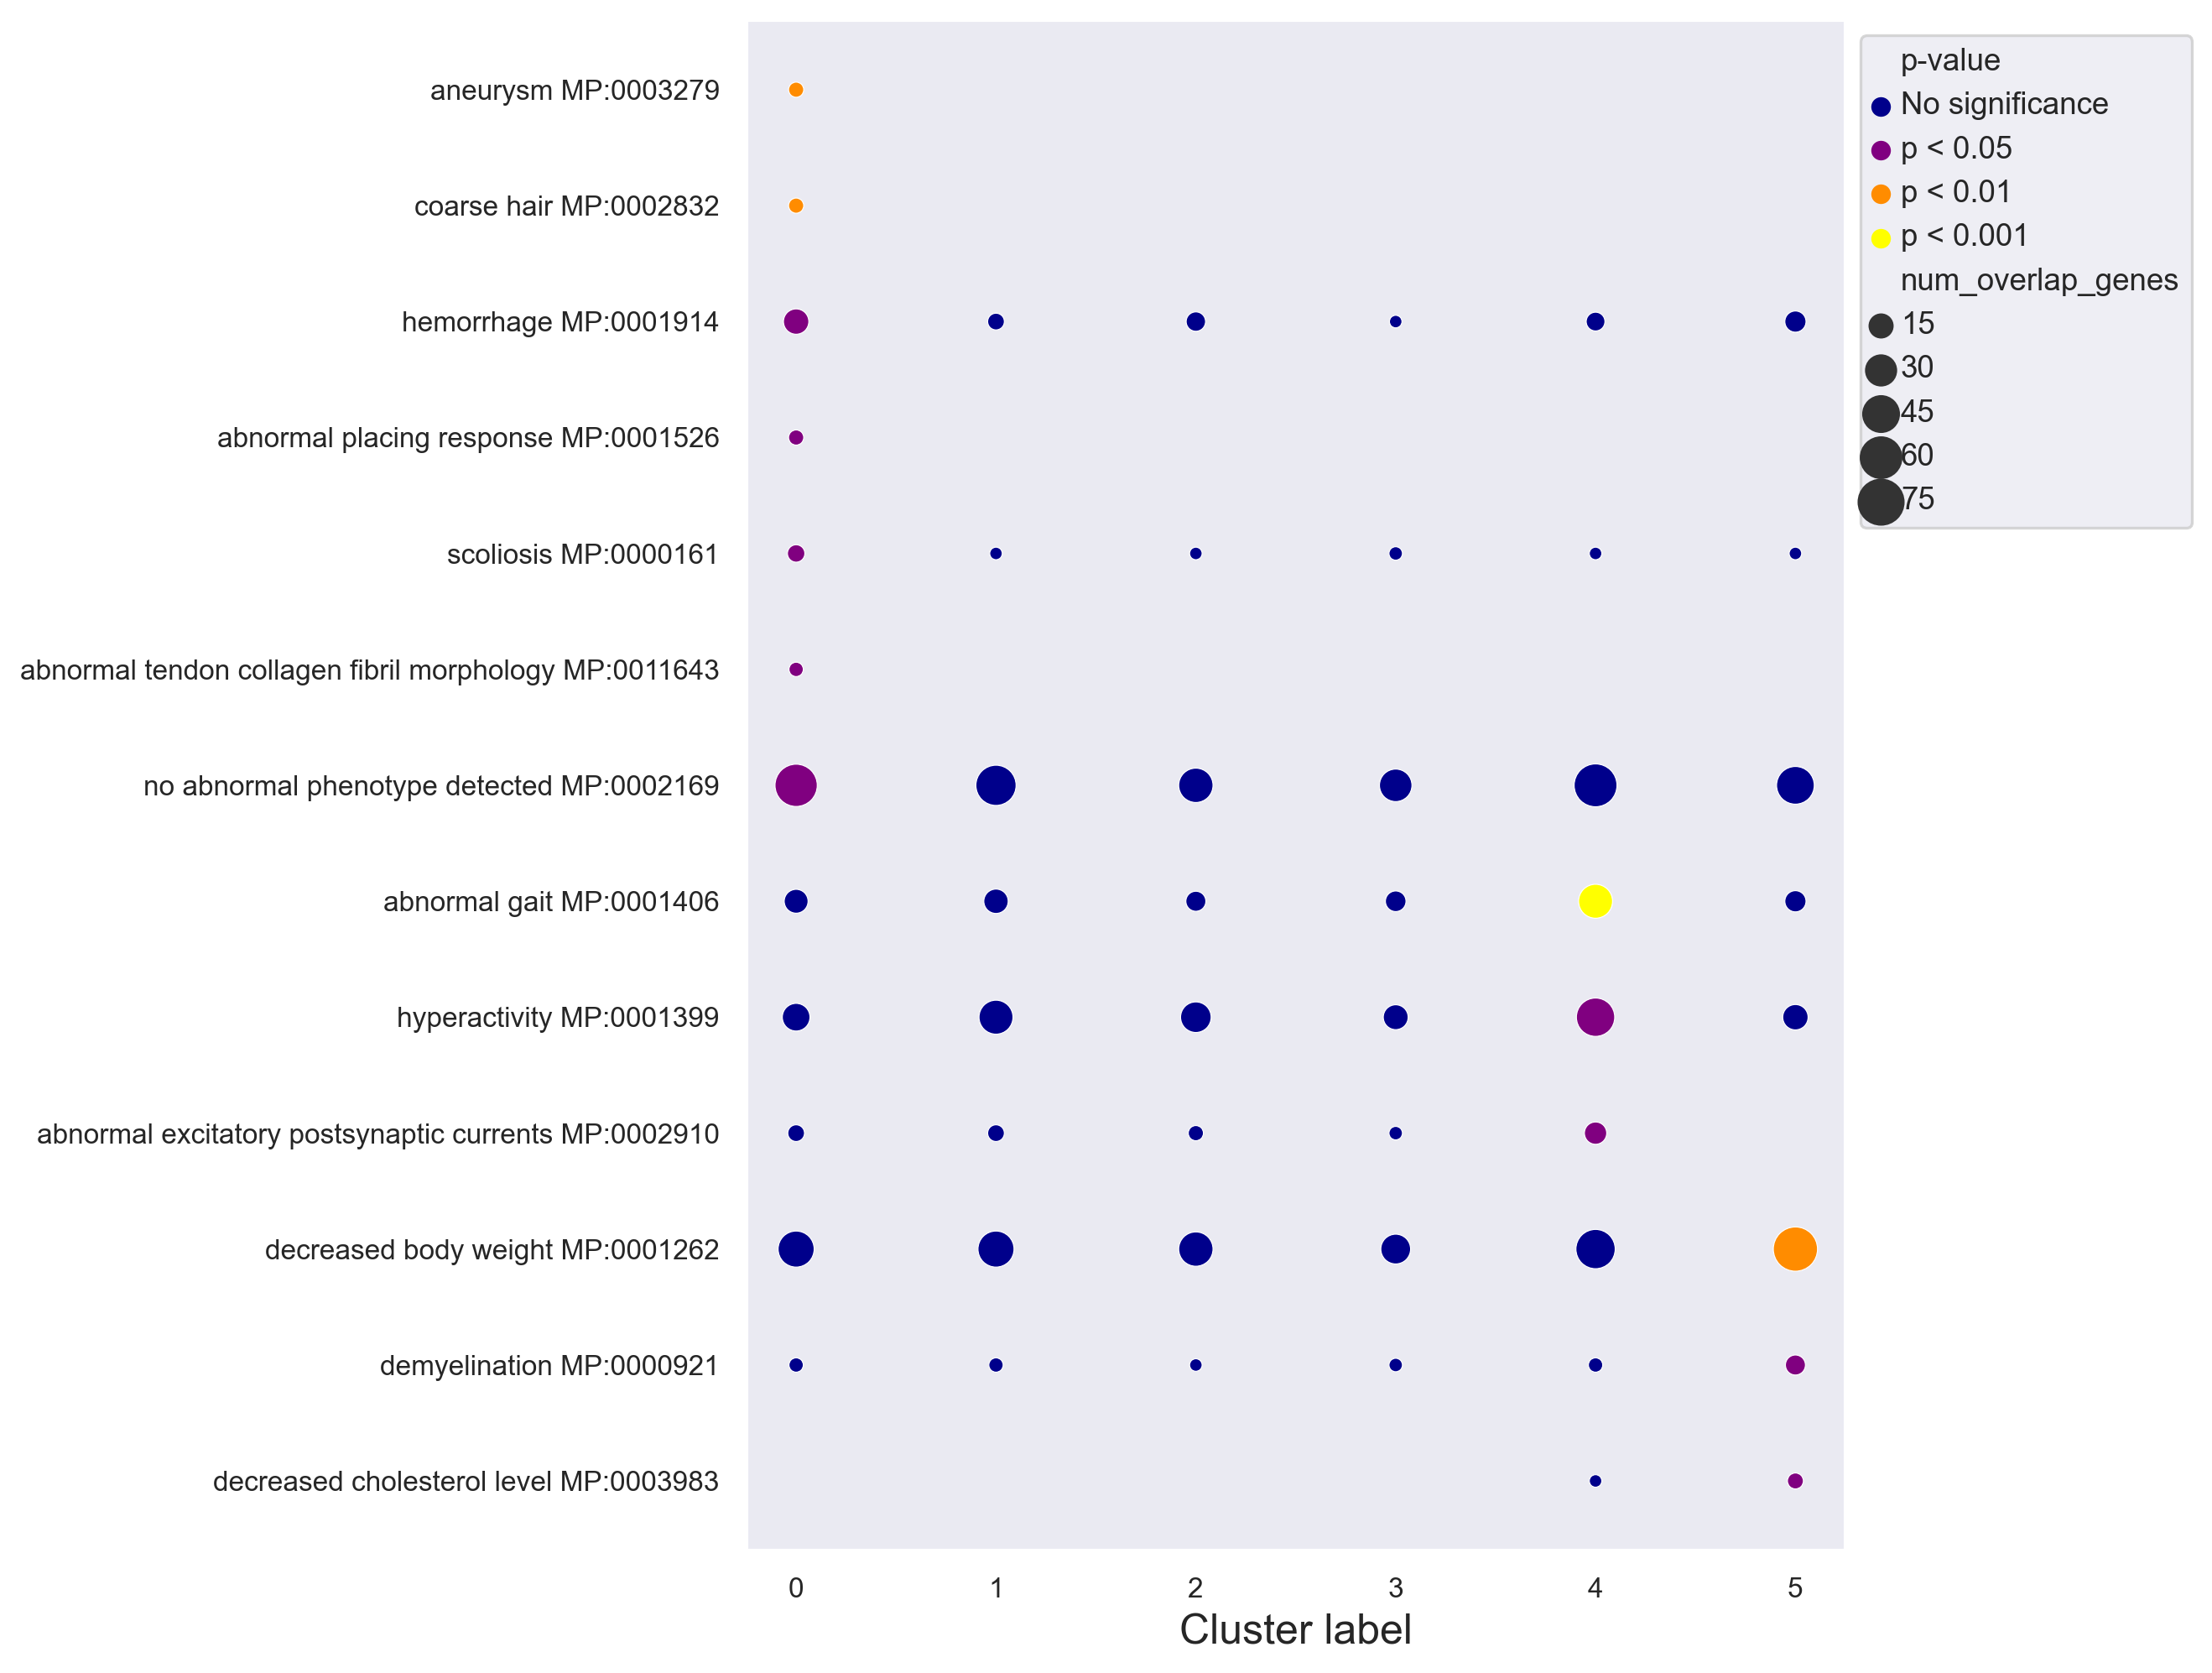

In [45]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [46]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [47]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank         p-val  \
Term                                                                     
Extracellular Matrix Organization R-HSA-1474244        1  4.580832e-09   
Eukaryotic Translation Elongation R-HSA-156842         2  5.953130e-06   
Peptide Chain Elongation R-HSA-156902                  3  1.533009e-05   
Collagen Formation R-HSA-1474290                       4  3.016423e-05   
Regulation Of IGF Transport And Uptake By IGFBP...     5  4.515973e-05   

                                                     Z-score  Combined score  \
Term                                                                           
Extracellular Matrix Organization R-HSA-1474244     4.921152       94.492931   
Eukaryotic Translation Elongation R-HSA-156842      5.396718       64.931115   
Peptide Chain Elongation R-HSA-156902               5.311165       58.877950   
Collagen Formation R-HSA-1474290                    6.979200       72.645473   
Regulation Of IGF Transport And Uptake By IGFBP...  4.670604       46.730817   

                                                                                    Overlapping genes  \
Term                                                                                                    
Extracellular Matrix Organization R-HSA-1474244     [ITGB1, CRTAP, COLGALT2, CD151, SDC2, FN1, BGN...   
Eukaryotic Translation Elongation R-HSA-156842      [RPL12, EEF2, RPS4X, EEF1A1, EEF1D, RPS3, RPL2...   
Peptide Chain Elongation R-HSA-156902               [RPS4X, EEF1A1, RPL12, RPS3, RPL22L1, RPS20, R...   
Collagen Formation R-HSA-1474290                    [COL1A1, COLGALT2, CRTAP, CD151, COL1A2, COL4A...   
Regulation Of IGF Transport And Uptake By IGFBP...  [IGFBP4, SDC2, IGFBP2, FN1, NUCB1, SCG3, IGFBP...   

                                                    Adjusted P-value  \
Term                                                                   
Extracellular Matrix Organization R-HSA-1474244             0.000005   
Eukaryotic Translation Elongation R-HSA-156842              0.003149   
Peptide Chain Elongation R-HSA-156902                       0.005406   
Collagen Formation R-HSA-1474290                            0.007243   
Regulation Of IGF Transport And Uptake By IGFBP...          0.007243   

                                                    Old p-value  \
Term                                                              
Extracellular Matrix Organization R-HSA-1474244               0   
Eukaryotic Translation Elongation R-HSA-156842                0   
Peptide Chain Elongation R-HSA-156902                         0   
Collagen Formation R-HSA-1474290                              0   
Regulation Of IGF Transport And Uptake By IGFBP...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Extracellular Matrix Organization R-HSA-1474244                        0   
Eukaryotic Translation Elongation R-HSA-156842                         0   
Peptide Chain Elongation R-HSA-156902                                  0   
Collagen Formation R-HSA-1474290                                       0   
Regulation Of IGF Transport And Uptake By IGFBP...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Extracellular Matrix Organization R-HSA-1474244                    24   
Eukaryotic Translation Elongation R-HSA-156842                     13   
Peptide Chain Elongation R-HSA-156902                              12   
Collagen Formation R-HSA-1474290                                    9   
Regulation Of IGF Transport And Uptake By IGFBP...                 12   

                                                    neg_log10(p_adj)  \
Term                                                                   
Extracellular Matrix Organization R-HSA-1474244             5.314570   


In [48]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

34

In [49]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

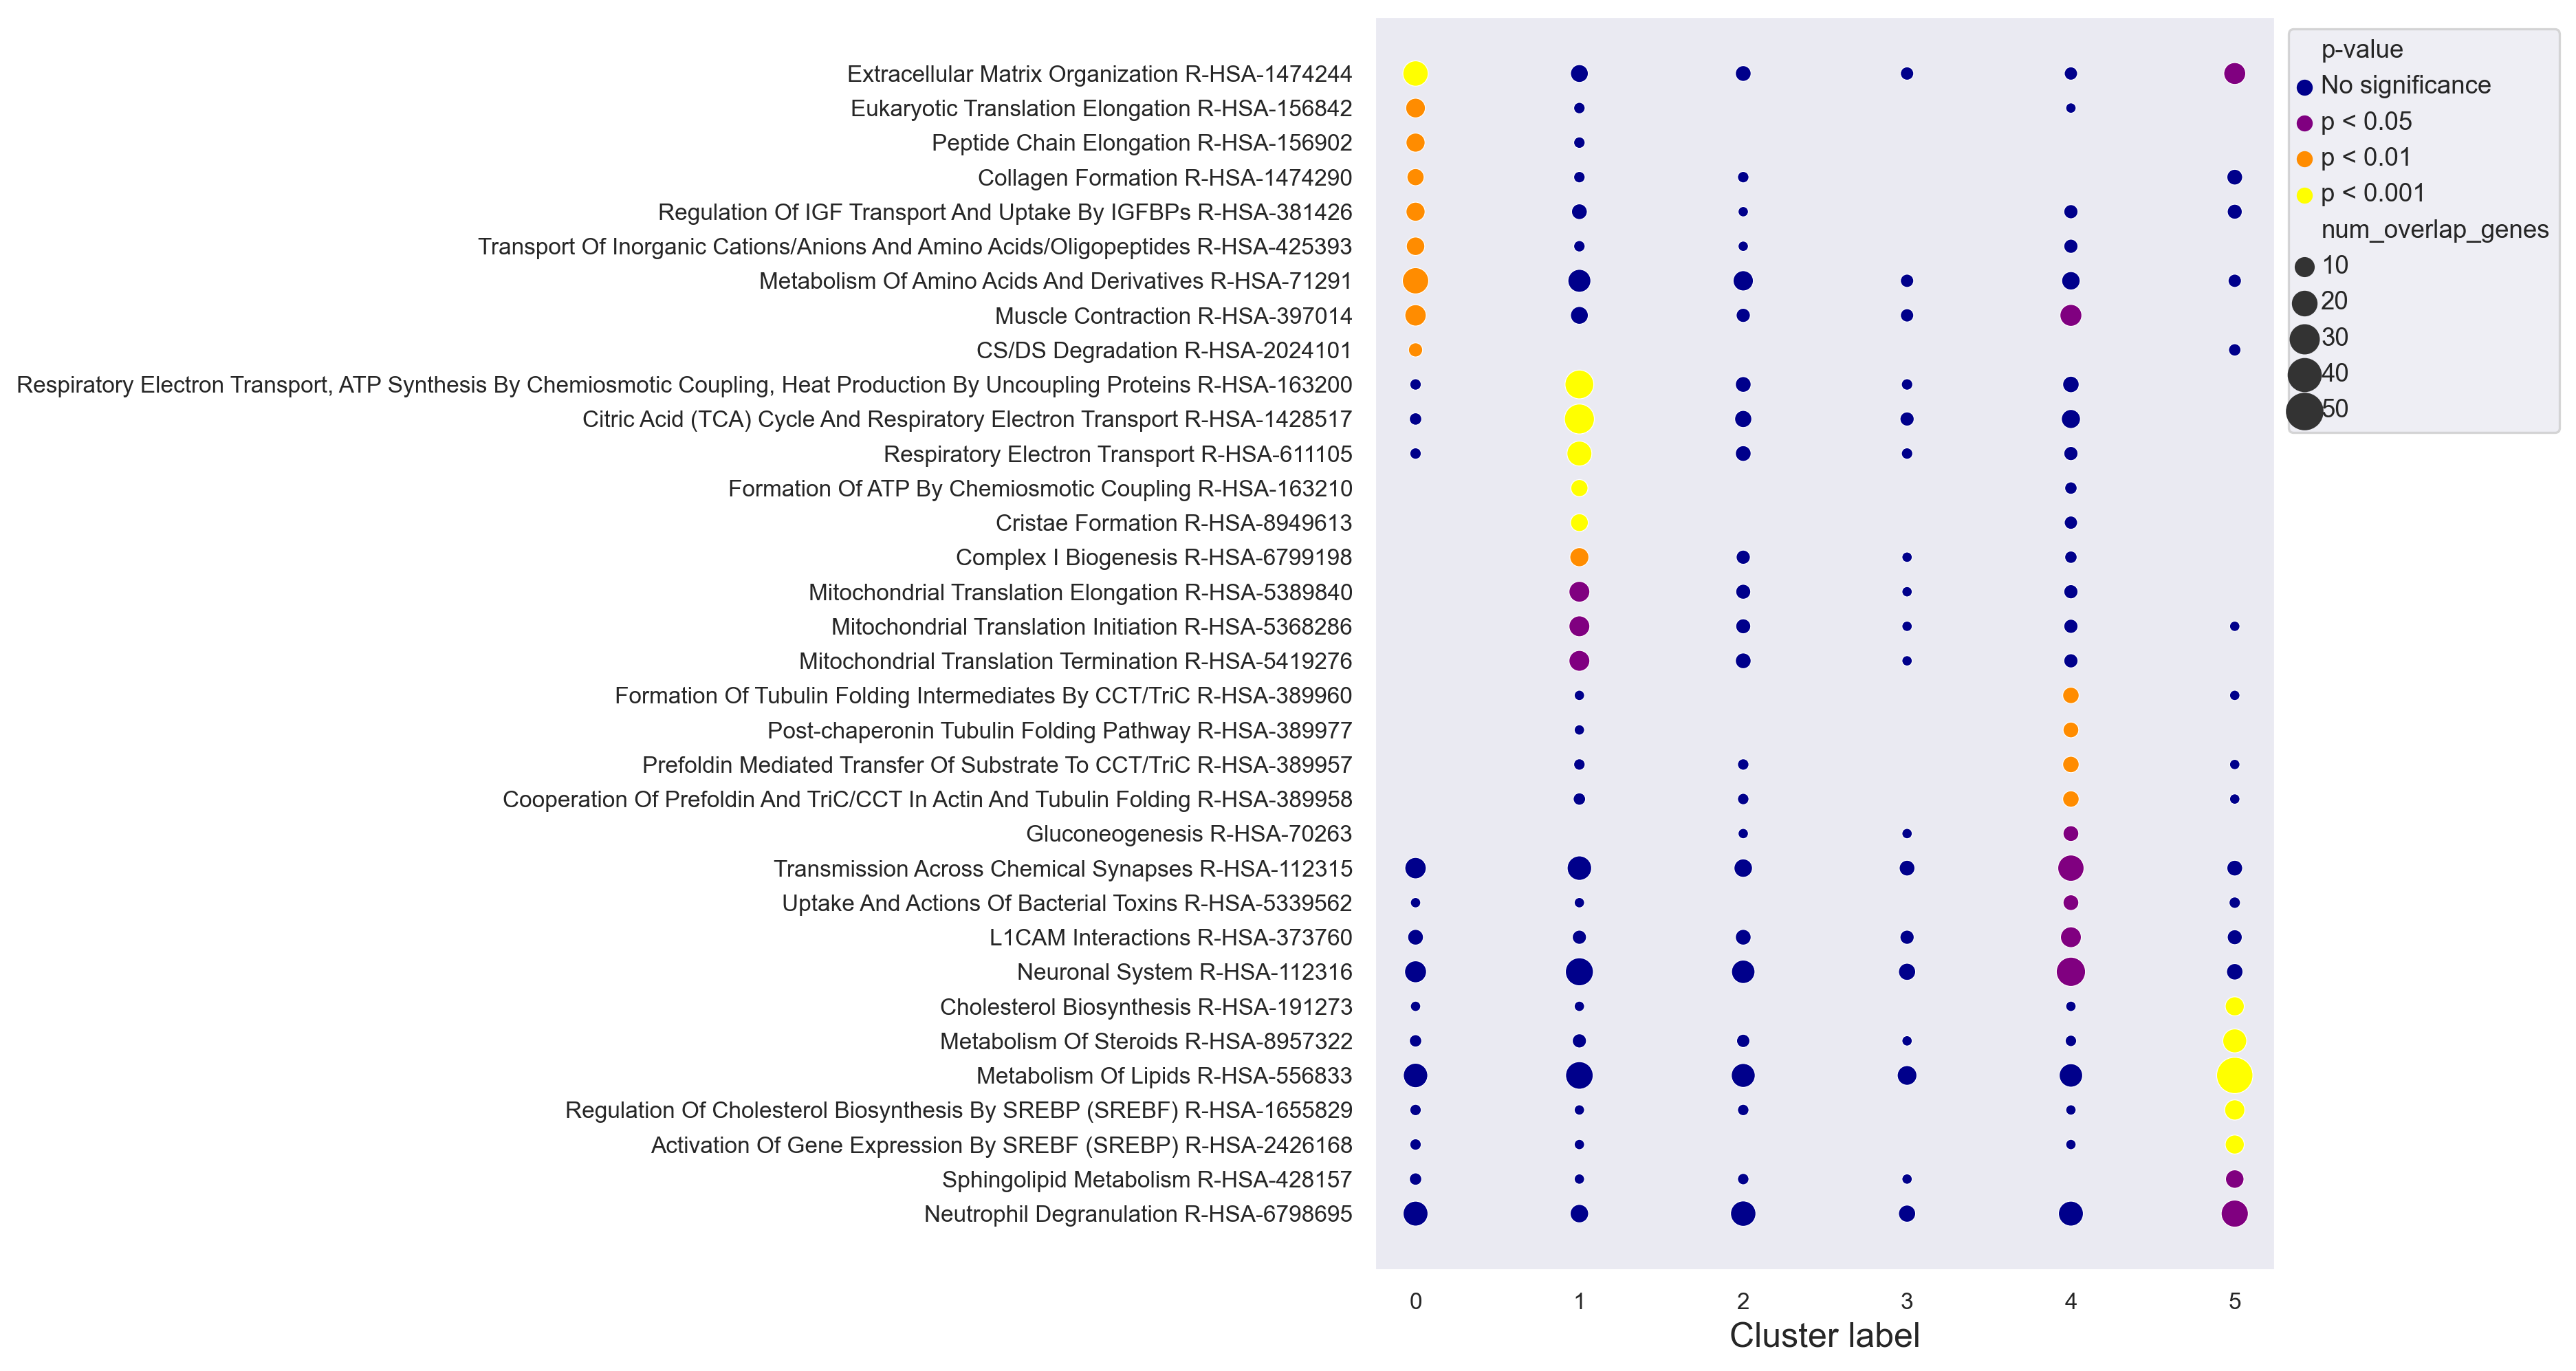

In [50]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [51]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [52]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank         p-val    Z-score  \
Term                                                                 
Protein digestion and absorption        1  5.009604e-07  10.803019   
ECM-receptor interaction                2  2.056157e-06   8.834784   
Complement and coagulation cascades     3  7.750702e-05  11.574834   
GABAergic synapse                       4  5.542644e-04   3.679226   
Coronavirus disease                     5  6.747546e-04   2.864004   

                                     Combined score  \
Term                                                  
Protein digestion and absorption         156.716575   
ECM-receptor interaction                 115.688602   
Complement and coagulation cascades      109.557451   
GABAergic synapse                         27.586351   
Coronavirus disease                       20.910554   

                                                                     Overlapping genes  \
Term                                                                                     
Protein digestion and absorption     [COL1A1, COL1A2, COL4A2, ELN, COL6A2, ATP1B3, ...   
ECM-receptor interaction             [ITGB1, COL1A1, RELN, COL1A2, COL4A2, LAMB2, C...   
Complement and coagulation cascades              [C1QB, SERPING1, CD59, TFPI, CLU, F3]   
GABAergic synapse                    [GABBR1, SLC32A1, GNAI3, SLC6A12, ABAT, SLC6A1...   
Coronavirus disease                  [C1QB, RPL12, MAPK12, TNFRSF1A, NFKBIA, RPS4X,...   

                                     Adjusted P-value  Old p-value  \
Term                                                                 
Protein digestion and absorption             0.000135            0   
ECM-receptor interaction                     0.000277            0   
Complement and coagulation cascades          0.006950            0   
GABAergic synapse                            0.030377            0   
Coronavirus disease                          0.030377            0   

                                     Old adjusted p-value  num_overlap_genes  \
Term                                                                           
Protein digestion and absorption                        0                 10   
ECM-receptor interaction                                0                 10   
Complement and coagulation cascades                     0                  6   
GABAergic synapse                                       0                 11   
Coronavirus disease                                     0                 15   

                                     neg_log10(p_adj)  cluster_label  
Term                                                                  
Protein digestion and absorption             3.870444              0  
ECM-receptor interaction                     3.558221              0  
Complement and coagulation cascades          2.158028              0  
GABAergic synapse                            1.517458              0  
Coronavirus disease                          1.517458              0

In [53]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

22

In [54]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

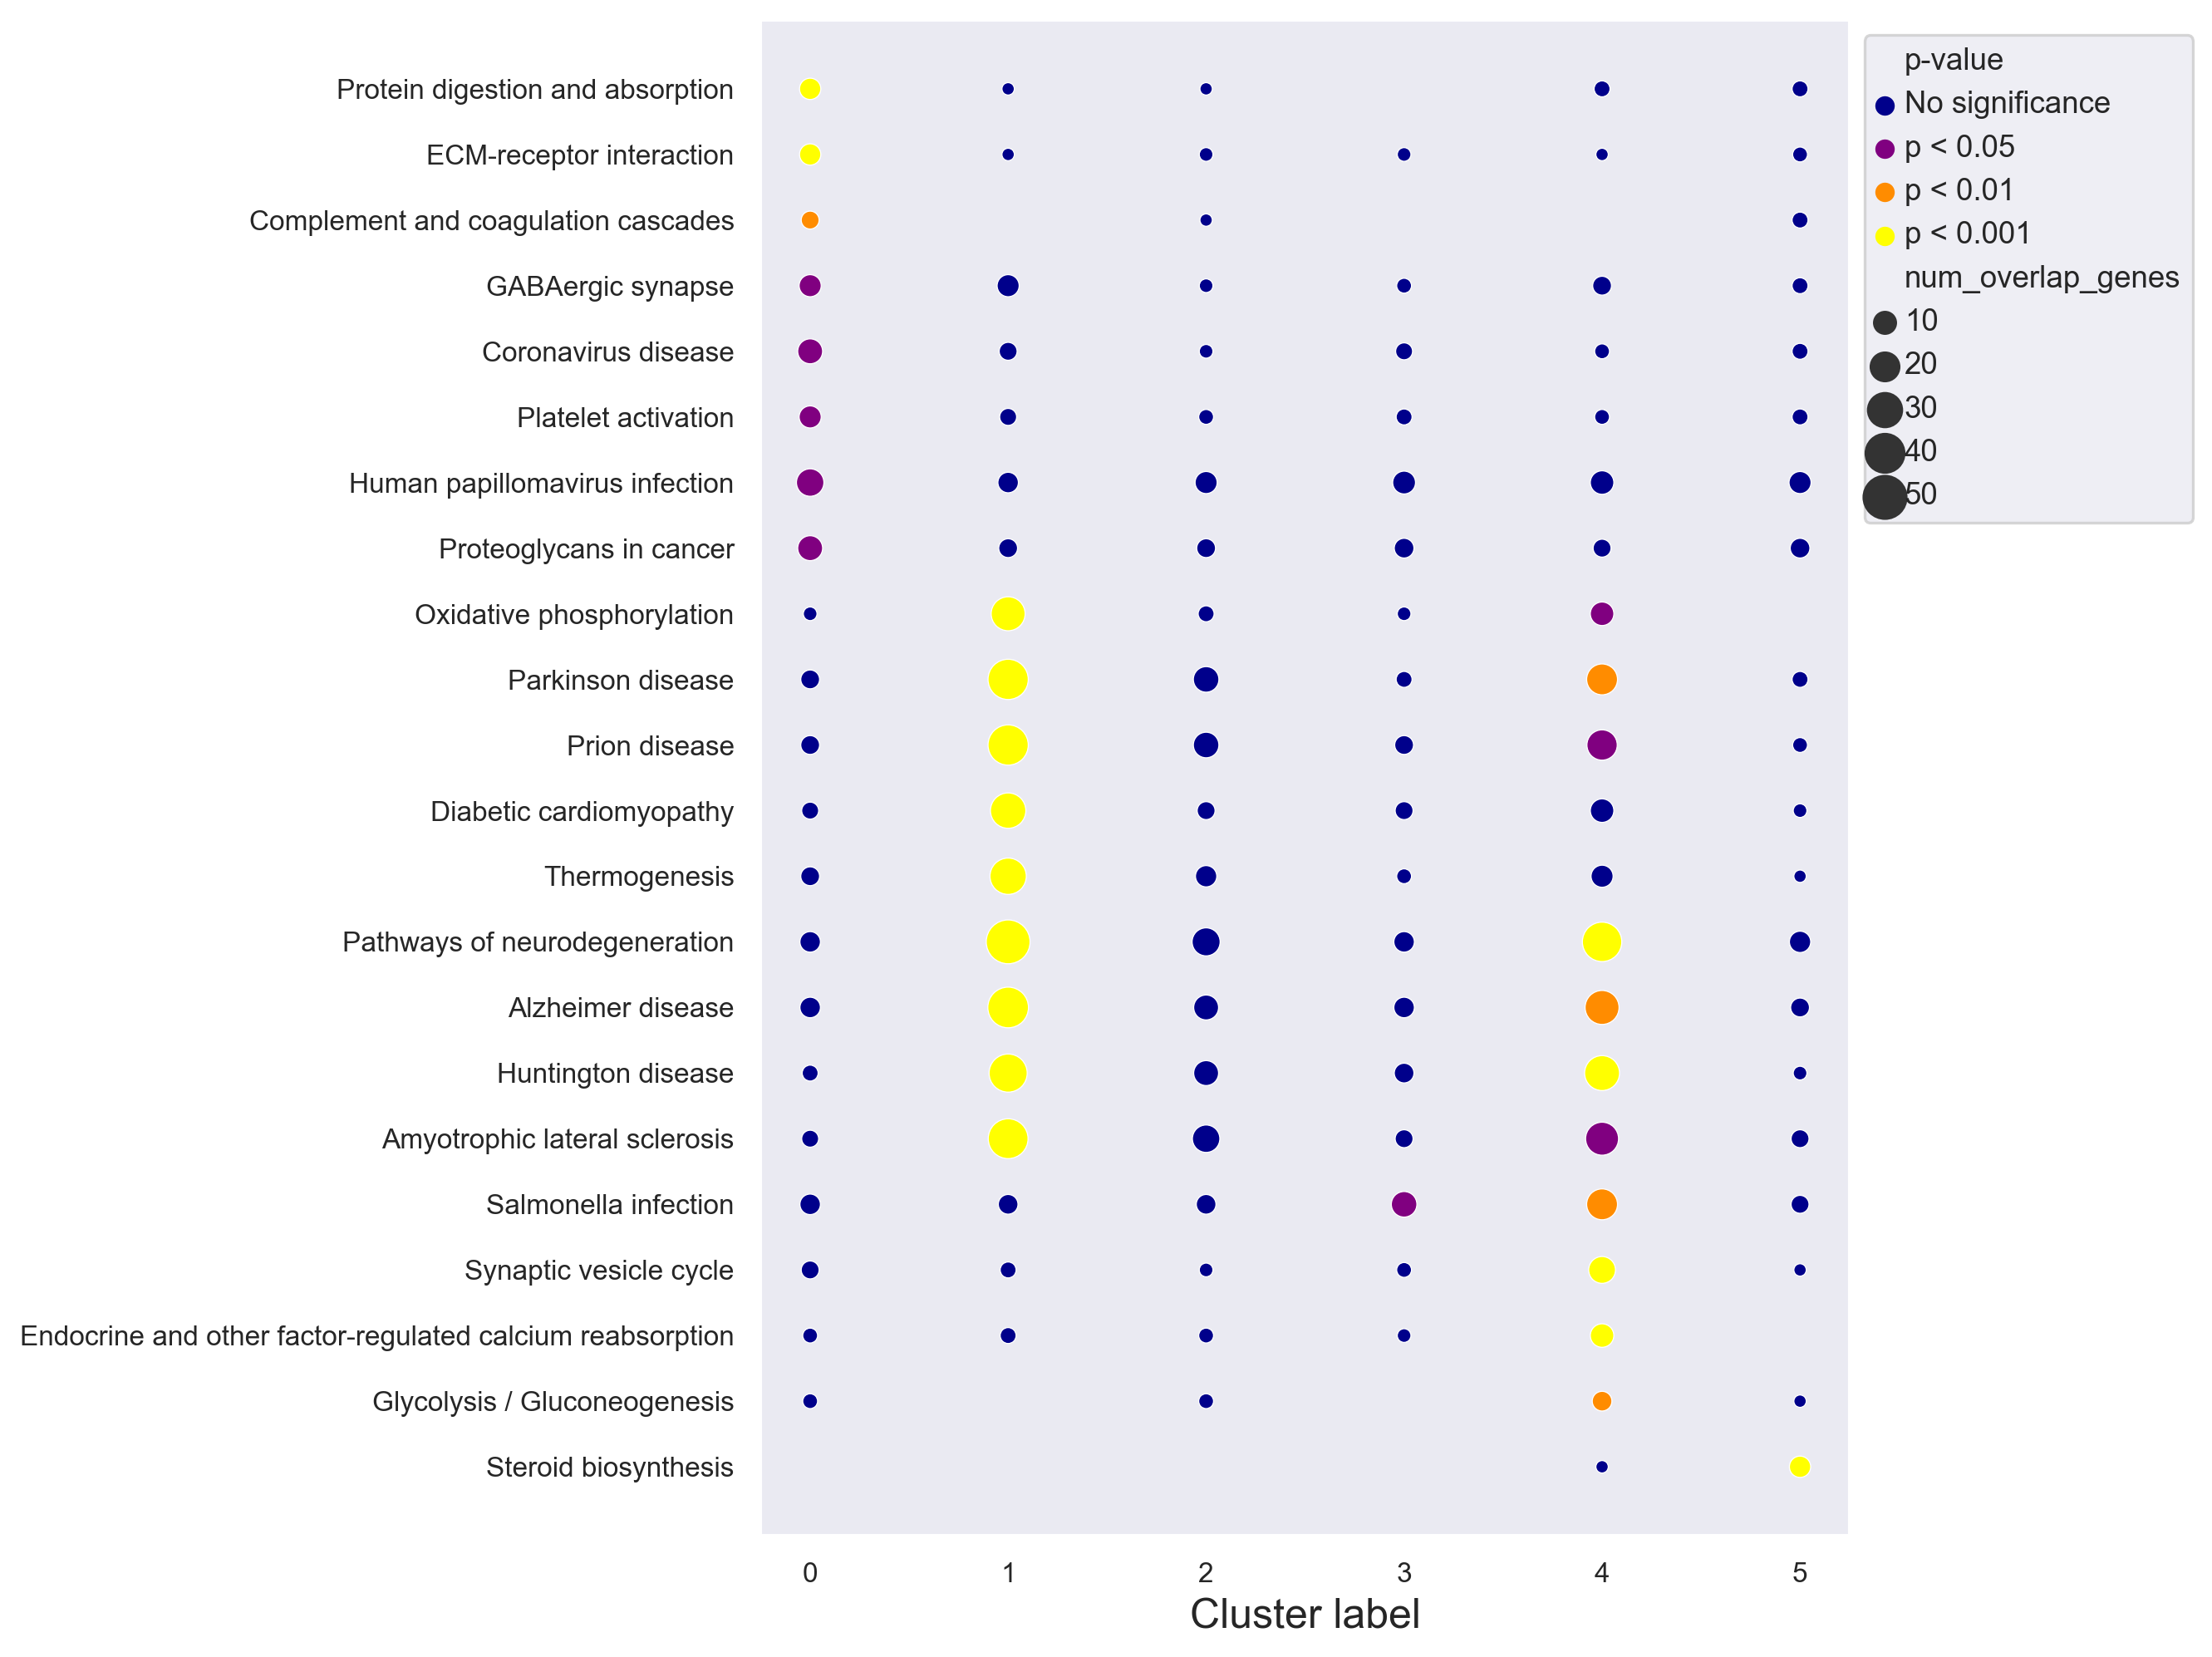

In [55]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))